In [1]:
pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-od30ewu4
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-od30ewu4
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 1.9 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33809 sha256=36fe869f7e53a59bbba7f87f004504db5e501811c27aabd09d218ec0316c8b21
  Stored in directory: /tmp/pip-ephem-wheel-cache-c5w5347n/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [2]:
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, UpSampling3D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session


import numpy as np
from numpy import unravel_index
import pandas as pd

from os import listdir
import os, os.path

import glob

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import skimage.measure
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score

from PIL import Image

import re
import gc

import time

In [3]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
0.0
1.0


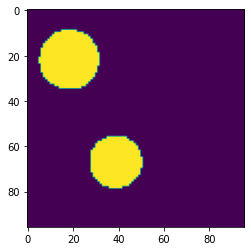

In [6]:
filepath = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Images96x96_newData(Normalized_maxpool_3D)'
imageDict = {}
for filename in os.listdir(filepath):
    path = os.path.join(filepath, filename)
    key = filename.split('.')[0]
    imageDict[key] = np.load(path,allow_pickle=True)
    print('Loaded: '+ key)
    print(imageDict[key].shape)


plt.imshow(imageDict['data_2_105_74'][70,:,:,0])
print(imageDict['data_2_105_74'][70].min())
print(imageDict['data_2_105_74'][70].max())

Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
-0.07724143392053406
4.328437686141806


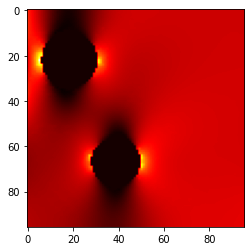

In [7]:
DIR = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Stress96x96_newData(Normalized_maxpool_3D)'
matrixDict = {}
for filename in os.listdir(DIR):
    path = os.path.join(DIR, filename)
    key = filename.split('.')[0]
    matrixDict[key] = np.load(path)
    print('Loaded: '+ key)
    print(matrixDict[key].shape)
    
plt.imshow(matrixDict['data_2_105_74'][70][:,:,0], cmap='hot')
print(matrixDict['data_2_105_74'][70].min())
print(matrixDict['data_2_105_74'][70].max())

In [8]:
# Combine X datas
x = np.concatenate((imageDict['data_2_105_74'], imageDict['data_2_115_65'],
                    imageDict['data_2_91_89'],imageDict['data_4_105_74'],imageDict['data_4_115_65'],
                    imageDict['data_4_91_89'], imageDict['data_6_91_89'], imageDict['data_6_105_74'],
                    imageDict['data_6_115_65'],), axis = 0)   
x.shape

(1800, 96, 96, 3)

In [9]:
# Combine Y datas 
y = np.concatenate((matrixDict['data_2_105_74'], matrixDict['data_2_115_65'],
                    matrixDict['data_2_91_89'],matrixDict['data_4_105_74'],matrixDict['data_4_115_65'],
                    matrixDict['data_4_91_89'], matrixDict['data_6_91_89'], matrixDict['data_6_105_74'],
                    matrixDict['data_6_115_65'],), axis = 0) 
y.shape

(1800, 96, 96, 3)

In [10]:
# Since there are total 1100 images,
# training data is 90% : 990
# testing data is 10% : 110
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1, 
                                                    random_state=42)

print('Shape of x_train',x_train.shape,'\n',
      'Shape of x_test',x_test.shape,'\n', 
      'Shape of y_train',y_train.shape,'\n', 
      'Shape of y_test',y_test.shape)

Shape of x_train (1620, 96, 96, 3) 
 Shape of x_test (180, 96, 96, 3) 
 Shape of y_train (1620, 96, 96, 3) 
 Shape of y_test (180, 96, 96, 3)


In [11]:
# For observing effects of data size, 

idx = np.random.randint(1620, size=100)
x_train_100 = x_train[idx,:,:,:]
y_train_100 = y_train[idx,:,:,:]
print('Shape of x_train_100',x_train_100.shape,'\n',
      'Shape of y_train_100',y_train_100.shape,'\n')

idx = np.random.randint(1620, size=300)
x_train_300 = x_train[idx,:,:,:]
y_train_300 = y_train[idx,:,:,:]
print('Shape of x_train_300',x_train_300.shape,'\n',
      'Shape of y_train_300',y_train_300.shape,'\n')

idx = np.random.randint(1620, size=500)
x_train_500 = x_train[idx,:,:,:]
y_train_500 = y_train[idx,:,:,:]
print('Shape of x_train_500',x_train_500.shape,'\n',
      'Shape of y_train_500',y_train_500.shape,'\n')

idx = np.random.randint(1620, size=700)
x_train_700 = x_train[idx,:,:,:]
y_train_700 = y_train[idx,:,:,:]
print('Shape of x_train_700',x_train_700.shape,'\n',
      'Shape of y_train_700',y_train_700.shape,'\n')

idx = np.random.randint(1620, size=900)
x_train_900 = x_train[idx,:,:,:]
y_train_900 = y_train[idx,:,:,:]
print('Shape of x_train_900',x_train_900.shape,'\n',
      'Shape of y_train_900',y_train_900.shape,'\n')

idx = np.random.randint(1620, size=1100)
x_train_1100 = x_train[idx,:,:,:]
y_train_1100 = y_train[idx,:,:,:]
print('Shape of x_train_1100',x_train_1100.shape,'\n',
      'Shape of y_train_1100',y_train_1100.shape,'\n')

idx = np.random.randint(1620, size=1300)
x_train_1300 = x_train[idx,:,:,:]
y_train_1300 = y_train[idx,:,:,:]
print('Shape of x_train_1300',x_train_1300.shape,'\n',
      'Shape of y_train_1300',y_train_1300.shape,'\n')

x_train_1620 = np.copy(x_train)
y_train_1620 = np.copy(y_train)
print('Shape of x_train_1620',x_train_1620.shape,'\n',
      'Shape of y_train_1620',y_train_1620.shape)

Shape of x_train_100 (100, 96, 96, 3) 
 Shape of y_train_100 (100, 96, 96, 3) 

Shape of x_train_300 (300, 96, 96, 3) 
 Shape of y_train_300 (300, 96, 96, 3) 

Shape of x_train_500 (500, 96, 96, 3) 
 Shape of y_train_500 (500, 96, 96, 3) 

Shape of x_train_700 (700, 96, 96, 3) 
 Shape of y_train_700 (700, 96, 96, 3) 

Shape of x_train_900 (900, 96, 96, 3) 
 Shape of y_train_900 (900, 96, 96, 3) 

Shape of x_train_1100 (1100, 96, 96, 3) 
 Shape of y_train_1100 (1100, 96, 96, 3) 

Shape of x_train_1300 (1300, 96, 96, 3) 
 Shape of y_train_1300 (1300, 96, 96, 3) 

Shape of x_train_1620 (1620, 96, 96, 3) 
 Shape of y_train_1620 (1620, 96, 96, 3)


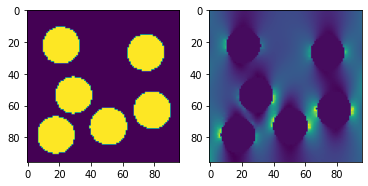

[[[1.39760626 1.39760626 1.39760626]
  [1.38870146 1.38870146 1.38870146]
  [1.3797279  1.3797279  1.3797279 ]
  ...
  [1.57863483 1.57863483 1.57863483]
  [1.61090384 1.61090384 1.61090384]
  [1.6431061  1.6431061  1.6431061 ]]

 [[1.39925912 1.39925912 1.39925912]
  [1.39021403 1.39021403 1.39021403]
  [1.38110018 1.38110018 1.38110018]
  ...
  [1.57998348 1.57998348 1.57998348]
  [1.61239262 1.61239262 1.61239262]
  [1.64473503 1.64473503 1.64473503]]

 [[1.38190394 1.38190394 1.38190394]
  [1.378327   1.378327   1.378327  ]
  [1.37468129 1.37468129 1.37468129]
  ...
  [1.57918127 1.57918127 1.57918127]
  [1.60283642 1.60283642 1.60283642]
  [1.62642484 1.62642484 1.62642484]]

 ...

 [[1.59481921 1.59481921 1.59481921]
  [1.52201345 1.52201345 1.52201345]
  [1.43972783 1.43972783 1.43972783]
  ...
  [1.62322798 1.62322798 1.62322798]
  [1.69844128 1.69844128 1.69844128]
  [1.77186963 1.77186963 1.77186963]]

 [[1.58361456 1.58361456 1.58361456]
  [1.51058147 1.51058147 1.51058147]


In [12]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train_100[71][:,:,0])
f.add_subplot(1,2, 2)
plt.imshow(y_train_100[71][:,:,0])
plt.show(block=True)
print(y_train_100[70])

In [13]:
# A function calculating Percentage Error
def percentage_err_3channels(y_pred, y_test):
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            for z in range(y_test.shape[3]):
                if(0 in y_test[idx]):
                    continue
                else:
                    err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                    arr.append(err)
    
    return abs(np.mean(arr))

# A function calculating Percentage Error with 1-channel
def percentage_err_1channel(y_pred, y_test): 
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            if(0 in y_test[idx,x,:]):
                continue
            else:
                err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                arr.append(err)
    
    return np.mean(arr)

# A Function to calculate R2 for each pore
def calculateR2_for_pores(preds, y_test, AVMat):
    b = []
    c = []
    TSS = 0
    RSS = 0
    
    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b
        
    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()
    
# A function to obtain AVMat
def calculateAVMat(y_test):
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])
    
    AVMat = AVMat/len(y_test)
    
    return AVMat

# A function calculates R2 score
def calculateR2(preds, y_test):
    b = []
    c = []
    TSS = 0
    RSS = 0
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])

    AVMat = AVMat/len(y_test)

    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b

    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()

# A function calculates MSE
def calculateMSE(dataA, dataB):
    errArray = []
    for i in range(len(dataA)):
        err = np.sum((dataA[i] - dataB[i]) ** 2)
        err /= float(dataA[i].shape[0] * dataA[i].shape[1])
        errArray.append(err)

    return sum(errArray) / len(errArray)

In [14]:
# Function reset the model
def reset_keras(model):
    sess = tf.compat.v1.keras.backend.get_session()
    clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [15]:
# Setting training configuration
batch_size = 16 #originally 100
epochs = 100 #30 originally
AVMat = []
R2Array_train = []
R2Array_test = []
MSEArray_train = []
MSEArray_test = []
err_train_3ch = []
err_test_3ch = []
err_train_1ch = []
err_test_1ch = []

In [16]:
AVMat = calculateAVMat(y_train)

In [17]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [18]:
from keras_applications.mobilenet import preprocess_input
BACKBONE = 'mobilenet'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE)
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   864         ['conv1_pad[0][0]']              
                             

In [19]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [20]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())

In [21]:
#Training with 100 data
%%time
model.fit(x_train_100, y_train_100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
7/7 [==============================] - 13s 202ms/step - loss: 0.5266
Epoch 2/100
7/7 [==============================] - 0s 42ms/step - loss: 0.3851
Epoch 3/100
7/7 [==============================] - 0s 41ms/step - loss: 0.3392
Epoch 4/100
7/7 [==============================] - 0s 41ms/step - loss: 0.3161
Epoch 5/100
7/7 [==============================] - 0s 41ms/step - loss: 0.3039
Epoch 6/100
7/7 [==============================] - 0s 41ms/step - loss: 0.2964
Epoch 7/100
7/7 [==============================] - 0s 41ms/step - loss: 0.2923
Epoch 8/100
7/7 [==============================] - 0s 41ms/step - loss: 0.2887
Epoch 9/100
7/7 [==============================] - 0s 41ms/step - loss: 0.2865
Epoch 10/100
7/7 [==============================] - 0s 41ms/step - loss: 0.2855
Epoch 11/100
7/7 [==============================] - 0s 43ms/step - loss: 0.2841
Epoch 12/100
7/7 [==============================] - 0s 41ms/step - loss: 0.2836
Epoch 13/100
7/7 [=============================

In [22]:
%%time
preds_train = model.predict(x_train_100)
preds = model.predict(x_test)

6/6 [==============================] - 1s 121ms/step
CPU times: user 1.93 s, sys: 51.3 ms, total: 1.98 s
Wall time: 2.56 s


In [23]:
%%time
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

reset_keras(model)

[0.24750384893342026]
[0.20194329495520538]
1937
CPU times: user 1.52 s, sys: 92.6 ms, total: 1.61 s
Wall time: 1.68 s


In [24]:
#Train with 300 data points

model.fit(x_train_300, y_train_300, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
19/19 [==============================] - 3s 112ms/step - loss: 0.2688
Epoch 2/100
19/19 [==============================] - 1s 45ms/step - loss: 0.2677
Epoch 3/100
19/19 [==============================] - 1s 45ms/step - loss: 0.2671
Epoch 4/100
19/19 [==============================] - 1s 46ms/step - loss: 0.2668
Epoch 5/100
19/19 [==============================] - 1s 46ms/step - loss: 0.2665
Epoch 6/100
19/19 [==============================] - 1s 45ms/step - loss: 0.2664
Epoch 7/100
19/19 [==============================] - 1s 46ms/step - loss: 0.2663
Epoch 8/100
19/19 [==============================] - 1s 46ms/step - loss: 0.2661
Epoch 9/100
19/19 [==============================] - 1s 45ms/step - loss: 0.2660
Epoch 10/100
19/19 [==============================] - 1s 46ms/step - loss: 0.2659
Epoch 11/100
19/19 [==============================] - 1s 45ms/step - loss: 0.2659
Epoch 12/100
19/19 [==============================] - 1s 46ms/step - loss: 0.2659
Epoch 13/100
19/19 [====

In [25]:
%%time
preds_train = model.predict(x_train_300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 18ms/step
CPU times: user 686 ms, sys: 14.3 ms, total: 701 ms
Wall time: 691 ms


In [26]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_300))
MSEArray_test.append(calculateMSE(preds, y_test))

In [27]:
print(R2Array_train)
print(R2Array_test)

[0.24750384893342026, 0.2277107997843866]
[0.20194329495520538, 0.2085616139593602]


In [28]:
#Train with 500 data points

model.fit(x_train_500, y_train_500, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
32/32 [==============================] - 2s 47ms/step - loss: 0.2770
Epoch 2/100
32/32 [==============================] - 1s 45ms/step - loss: 0.2766
Epoch 3/100
32/32 [==============================] - 1s 45ms/step - loss: 0.2761
Epoch 4/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2758
Epoch 5/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2757
Epoch 6/100
32/32 [==============================] - 1s 45ms/step - loss: 0.2756
Epoch 7/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2756
Epoch 8/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2755
Epoch 9/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2752
Epoch 10/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2752
Epoch 11/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2751
Epoch 12/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2751
Epoch 13/100
32/32 [=====

In [29]:
%%time
preds_train = model.predict(x_train_500)
preds = model.predict(x_test)

6/6 [==============================] - 0s 18ms/step
CPU times: user 593 ms, sys: 9.88 ms, total: 603 ms
Wall time: 684 ms


In [30]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_500))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_500))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_500))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.24750384893342026, 0.2277107997843866, 0.22287954347081096]
[0.20194329495520538, 0.2085616139593602, 0.21007982575483305]


In [31]:
#Train with 700 data points

model.fit(x_train_700, y_train_700, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
44/44 [==============================] - 2s 47ms/step - loss: 0.2852
Epoch 2/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2848
Epoch 3/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2845
Epoch 4/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2844
Epoch 5/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2842
Epoch 6/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2840
Epoch 7/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2839
Epoch 8/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2838
Epoch 9/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2837
Epoch 10/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2837
Epoch 11/100
44/44 [==============================] - 2s 46ms/step - loss: 0.2836
Epoch 12/100
44/44 [==============================] - 2s 47ms/step - loss: 0.2837
Epoch 13/100
44/44 [=====

In [32]:
%%time
preds_train = model.predict(x_train_700)
preds = model.predict(x_test)

6/6 [==============================] - 0s 17ms/step
CPU times: user 1.36 s, sys: 26.2 ms, total: 1.38 s
Wall time: 1.57 s


In [33]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_700))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_700))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_700))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.24750384893342026, 0.2277107997843866, 0.22287954347081096, 0.21966884592915323]
[0.20194329495520538, 0.2085616139593602, 0.21007982575483305, 0.21026729811052758]


In [34]:
#Train with 900 data points

model.fit(x_train_900, y_train_900, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2798
Epoch 2/100
57/57 [==============================] - 3s 45ms/step - loss: 0.2795
Epoch 3/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2791
Epoch 4/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2790
Epoch 5/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2788
Epoch 6/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2788
Epoch 7/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2787
Epoch 8/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2786
Epoch 9/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2785
Epoch 10/100
57/57 [==============================] - 3s 47ms/step - loss: 0.2784
Epoch 11/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2783
Epoch 12/100
57/57 [==============================] - 3s 47ms/step - loss: 0.2783
Epoch 13/100
57/57 [=====

In [35]:
%%time
preds_train = model.predict(x_train_900)
preds = model.predict(x_test)

6/6 [==============================] - 0s 17ms/step
CPU times: user 954 ms, sys: 27.2 ms, total: 981 ms
Wall time: 1.56 s


In [36]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_900))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_900))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_900))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.24750384893342026, 0.2277107997843866, 0.22287954347081096, 0.21966884592915323, 0.22724662188641173]
[0.20194329495520538, 0.2085616139593602, 0.21007982575483305, 0.21026729811052758, 0.2105921396729483]


In [37]:
#Train with 1100 data points

model.fit(x_train_1100, y_train_1100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
69/69 [==============================] - 3s 47ms/step - loss: 0.2790
Epoch 2/100
69/69 [==============================] - 3s 46ms/step - loss: 0.2787
Epoch 3/100
69/69 [==============================] - 3s 46ms/step - loss: 0.2785
Epoch 4/100
69/69 [==============================] - 3s 46ms/step - loss: 0.2783
Epoch 5/100
69/69 [==============================] - 3s 46ms/step - loss: 0.2782
Epoch 6/100
69/69 [==============================] - 3s 46ms/step - loss: 0.2780
Epoch 7/100
69/69 [==============================] - 3s 47ms/step - loss: 0.2780
Epoch 8/100
69/69 [==============================] - 3s 47ms/step - loss: 0.2779
Epoch 9/100
69/69 [==============================] - 3s 47ms/step - loss: 0.2779
Epoch 10/100
69/69 [==============================] - 3s 47ms/step - loss: 0.2779
Epoch 11/100
69/69 [==============================] - 3s 46ms/step - loss: 0.2778
Epoch 12/100
69/69 [==============================] - 3s 49ms/step - loss: 0.2778
Epoch 13/100
69/69 [=====

In [38]:
%%time
preds_train = model.predict(x_train_1100)
preds = model.predict(x_test)

6/6 [==============================] - 0s 17ms/step
CPU times: user 1.01 s, sys: 29.2 ms, total: 1.04 s
Wall time: 1.58 s


In [39]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.24750384893342026, 0.2277107997843866, 0.22287954347081096, 0.21966884592915323, 0.22724662188641173, 0.2256406526062711]
[0.20194329495520538, 0.2085616139593602, 0.21007982575483305, 0.21026729811052758, 0.2105921396729483, 0.21111959469344338]


In [40]:
#Train with 1300 data points

model.fit(x_train_1300, y_train_1300, 
          batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2648
Epoch 2/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2646
Epoch 3/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2644
Epoch 4/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2642
Epoch 5/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2642
Epoch 6/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2641
Epoch 7/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2640
Epoch 8/100
82/82 [==============================] - 4s 49ms/step - loss: 0.2640
Epoch 9/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2639
Epoch 10/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2639
Epoch 11/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2640
Epoch 12/100
82/82 [==============================] - 4s 46ms/step - loss: 0.2639
Epoch 13/100
82/82 [=====

In [41]:
%%time
preds_train = model.predict(x_train_1300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 17ms/step
CPU times: user 1.22 s, sys: 39.4 ms, total: 1.26 s
Wall time: 1.63 s


In [42]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1300))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.24750384893342026, 0.2277107997843866, 0.22287954347081096, 0.21966884592915323, 0.22724662188641173, 0.2256406526062711, 0.23483778906174246]
[0.20194329495520538, 0.2085616139593602, 0.21007982575483305, 0.21026729811052758, 0.2105921396729483, 0.21111959469344338, 0.21062734247033335]


In [43]:
#Train with 1620 data points

model.fit(x_train_1620, y_train_1620, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2777
Epoch 2/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2776
Epoch 3/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2774
Epoch 4/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2773
Epoch 5/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2772
Epoch 6/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2771
Epoch 7/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2771
Epoch 8/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2770
Epoch 9/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2770
Epoch 10/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2770
Epoch 11/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2769
Epoch 12/100
102/102 [==============================] - 5s 46ms/step - loss: 0.2769
E

In [44]:
%%time
preds_train = model.predict(x_train_1620)
preds = model.predict(x_test)

6/6 [==============================] - 0s 17ms/step
CPU times: user 1.34 s, sys: 95.9 ms, total: 1.44 s
Wall time: 1.67 s


In [45]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1620))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1620))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1620))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.24750384893342026, 0.2277107997843866, 0.22287954347081096, 0.21966884592915323, 0.22724662188641173, 0.2256406526062711, 0.23483778906174246, 0.2267729650358259]
[0.20194329495520538, 0.2085616139593602, 0.21007982575483305, 0.21026729811052758, 0.2105921396729483, 0.21111959469344338, 0.21062734247033335, 0.21097243312412212]
